In [1]:
import pickle
import sys
import numpy as np
from sklearn.cluster import KMeans
sys.path.append('/home/ardelalegre/SoundMapping/Analysis/Util')
from get_time_interval_data import *
from Tools import *
from PCA import get_cdata
from PCA import get_eigen_vectors
from PCA import project_to_eigen_vectors
from Plot import plot_data
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib as mpl

In [2]:
def data_init_SVD(exp_data):
    """ Takes data queried from SQL as argument, initializes it by converting all nans to column means
    Returns initialized data."""
    
    data = exp_data[:,1:]
    
    
    # all the nan values of this matrix should be replaced by the mean of the column that the nan is in
    # eg if we have a nan in column 0, we must replace it with the mean of that column
    data_column_means = np.nanmean(data, axis = 0)
    
    # Convert all nan in this data_column_means to 0
    data_column_means_num = np.where(data_column_means!=data_column_means,0,data_column_means) # nan is not equal to nan
    
    
    # Logic: In data, if an element is equal to nan, it should be replaced by the mean of the column it is in.
    # use broadcasting?
    data_init = np.where(data!=data, data_column_means_num, data)
    
    
    return(data_init)

In [3]:
room_model_chair = mpimg.imread('room_model_v2.png')

In [4]:
sample_time = 0.064

In [5]:
# extracting aug 19 data from pickle file

data_0819 = pickle.load(open('/home/ardelalegre/CSE4223-ODAS/preprocessing/python/aug 19/exp_08_19_better_data.p', 'rb'))
ind = [18]+[i for i in range(18)]
data_0819=data_0819[:,ind]


# creating eig_vals and eig_vecs from the data
eigen_values_0819, eigen_vectors_0819 = get_eigen_vectors(data_0819)




In [6]:
exp_data = get_time_interval_matrix_data('Nov 3 2020 04:00PM', 'Nov 3 2020 04:25PM')

In [7]:
data_mean = np.nanmean(exp_data[:,1:],axis = 0,keepdims = True)
tmp = exp_data[:,1:] - data_mean
exp_cdata=np.nan_to_num(tmp)

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


In [8]:
projections = project_to_eigen_vectors(exp_cdata, 2, eigen_values_0819, eigen_vectors_0819)

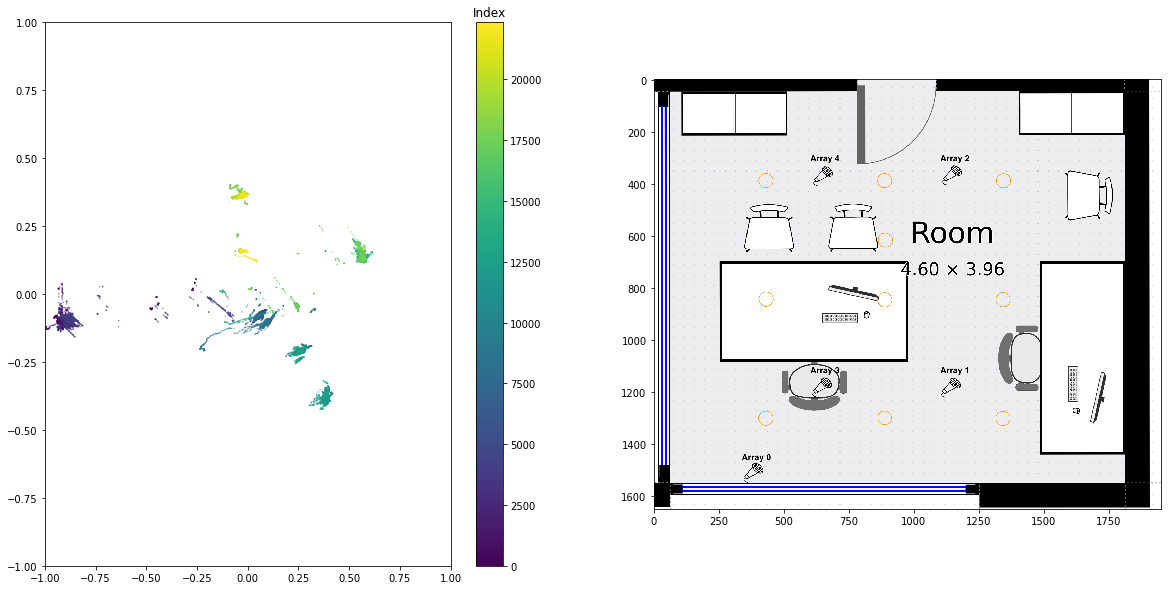

In [9]:
fig = plt.figure(figsize = [20,10])
ax = fig.add_subplot(121)
temp = ax.scatter(projections[:,0], projections[:,1], c = np.arange(projections.shape[0]), s = 0.1)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
cbar = fig.colorbar(temp, ax=ax)
cbar.ax.set_title('Index')

ax2 = fig.add_subplot(122)
ax2.imshow(room_model_chair[450:2100,450:2400])

#### Strange: 2 clusters where there is supposed to be 1. We will plot just those five minutes.


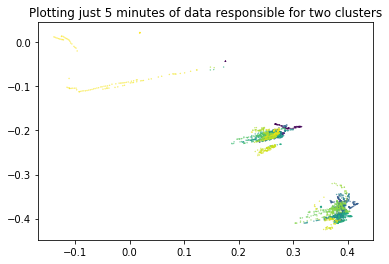

In [10]:
start_time = 'Nov 3 2020 04:10:00PM'
end_time = 'Nov 3 2020 04:15:00PM'

x,y = slice_interval_indices(exp_data, start_time, end_time)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(projections[x:y,0], projections[x:y,1], c = np.arange(y-x), s = 0.1)
ax.set_title('Plotting just 5 minutes of data responsible for two clusters');

#### Hypothesis: implementing iterative approximation of the data matrix will solve this problem.

$$\vec{r} = M (U - \vec{s})$$


here,

$r$: PCA coordinate vector

$M$ : Matrix whose rows are eigenvectors

$U$ : Matrix whose columns are measurement vectors. At init, the nans are replaced by the means for that column. (This should be the same as the mean for that array.)

$\vec{s}$ : Mean measurement vector

### Set up

#### Calculating $U$


#### I have made the assumption that it is okay to replace the all nan columns corresponding to defunct array 4 by zeros. 

In [13]:
data = exp_data[:,1:]
skeleton_data = data.T # this could be outside the loop.

In [14]:
data_init = data_init_SVD(exp_data)
U = data_init.T

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


#### Calculating $\vec{s}$

In [15]:
data_mean = np.nanmean(data, axis = 0)
# we need to replace nan corresponding to array 4 by 0
s = np.where(data_mean!=data_mean, 0, data_mean)
s = s.reshape(18,1)

/home/ardelalegre/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


#### Determining M: For now we choose M to be a 18x18 matrix, where the rows are the sorted eigenvectors in descending order. We do this because this makes it easy for us to determine the new U, since square matrices are invertible.

In [18]:
eig_val_sorted_indices = np.argsort(eigen_values_0819)
eig_val_sorted_indices = eig_val_sorted_indices[-1::-1]
sorted_eigvec = eigen_vectors_0819[:,eig_val_sorted_indices]

In [19]:
M = sorted_eigvec.T

#### Step 1 : Calculating r

In [20]:
r = M@(U-s)

#### Sanity check: This is our usual affine transformation. How do the top two eigenvector projections look at this point?

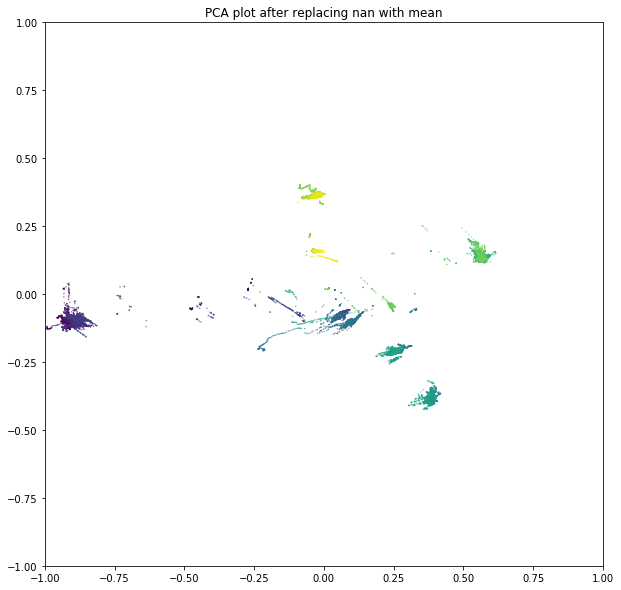

In [21]:
all_proj = r.T

# all_proj.shape
fig = plt.figure(figsize=[10,10])
ax = fig.add_subplot(111)
ax.scatter(all_proj[:,0], all_proj[:,1], c = np.arange(all_proj.shape[0]), s = 0.1)
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_title('PCA plot after replacing nan with mean');

#### Step 2: Calculating U from r.

$$ U = M^{-1}\vec{r} + \vec{s}$$

#### The catch is, we need to update only the unknown entries of U.

In [22]:
temp_U = (np.linalg.inv(M)@r) + s

#### logic: in the updated U, replace all the elements of the previous U that were nan, by the corresponding values of temp_U

In [23]:
updated_U = np.where(skeleton_data!=skeleton_data, temp_U, skeleton_data) 

#### This should repeat until a certain condition is reached.  
#### Presumably, the Euclidean distance between resultant updated U for two consequtive iterations should not change by much after a point.

#### We will try running this in a loop 10000 times

In [24]:
num_iter = 20000

In [25]:
eu_d = []

updated_U = U

for i in range(num_iter):
    
    r = M@(updated_U-s)
    
    temp_U = (np.linalg.inv(M)@r) + s
    
    prev = updated_U # to find how much U is changing
    
    updated_U = np.where(skeleton_data!=skeleton_data, temp_U, skeleton_data)
    
    # verification - euc dist between prev and updated
    
    euc_dist = np.sum((prev-updated_U)**2)
    eu_d.append(euc_dist)

#### Plotting Euclidean Distance between U for consequtive iterations

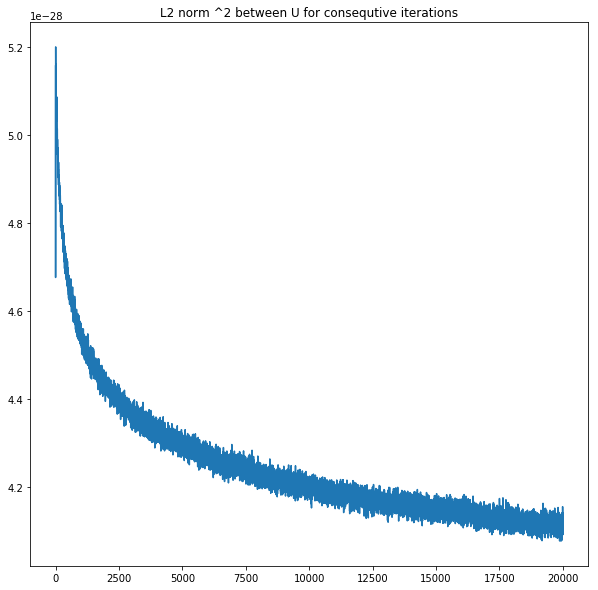

In [26]:
plt.figure(figsize=[10,10])
plt.plot(eu_d)
plt.title('L2 norm ^2 between U for consequtive iterations');

#### How do the projections look now?

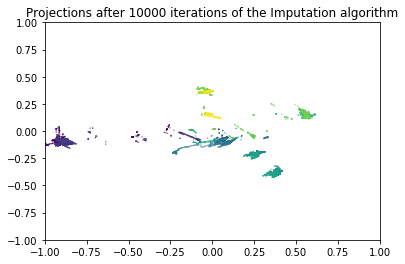

In [27]:
# the first two rows of U are our projections

r = M@(updated_U-s)

all_proj2 = r.T
plt.scatter(all_proj2[:,0], all_proj2[:,1], c=np.arange(all_proj2.shape[0]), s = 0.1)
plt.title('Projections after 10000 iterations of the Imputation algorithm')
plt.xlim(-1,1)
plt.ylim(-1,1);

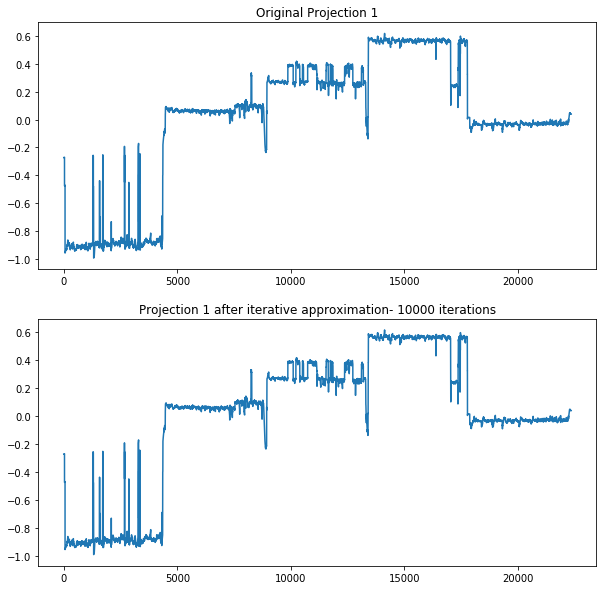

In [28]:
fig = plt.figure(figsize = [10,10])
ax1 = fig.add_subplot(211)
ax1.plot(all_proj[:,0])
ax1.set_title('Original Projection 1')
ax2 = fig.add_subplot(212)
ax2.plot(all_proj2[:,0])
ax2.set_title('Projection 1 after iterative approximation- 10000 iterations');